# Testing Asteroseismic Radii of Dwarf Stars with Gaia Parallaxes

## Supporting material for the paper "Asteroseismic Radii of Dwarfs: New Accuracy Constraints From Gaia DR2 Parallaxes"
#### Christian L. Sahlholdt, Victor Silva Aguirre

In this notebook we derive the radii of a sample of almost a hundred dwarf stars based on their parallaxes measured by the [Gaia spacecraft](http://www.esa.int/Our_Activities/Space_Science/Gaia_overview) and their angular diameters determined from the infrared flux method in a previous study ([Sahlholdt et al. 2018](https://academic.oup.com/mnras/article/476/2/1931/4848283)).
By comparing these radii to the ones based on [asteroseismology](https://en.wikipedia.org/wiki/Asteroseismology), we test the accuracy of the asteroseismic radii.

See README.md for help on running this notebook.

## Contents
* [Introduction](#intro)


* [Computing Stellar Radii](#stel_rad)
    * [Stellar Data](#stel_data)
    * [Scaling Relation Parameters](#scal_par)
    * [Calculation of Gaia Radii](#rad_calc)


* [Comparison Between Seismic and Gaia Radii](#gaia_comp)
    * [Error Distributions](#err_dist)
    * [Absolute Differences](#abs_diff)
    * [Relative Differences](#rel_diff)


* [Correcting the Scaling Relations](#scal_corr)


* [References](#ref)

## Introduction <a class="anchor" id="intro"></a>

Precise and accurate stellar parameters like masses, radii, and ages are crucial in many different fields of astronomy.
In recent years, the field of asteroseismology, which is the study of intrinsic stellar oscillations, has seen great progress as a means of determining stellar parameters with high precision.
Just like seismic measurements of earthquakes reveal the inner structure of Earth, measurements of stellar pulsations provide information about the star's interior.
For a star like the Sun, the outer layers undergo powerful convective motion which excites a rich spectrum of oscillation modes, and each individual pulsation carries information about the stellar structure.
This enables a determination of the stellar properties by matching the observed oscillations to those of a stellar model.

It is not always possible to determine the individual oscillation frequencies due to their very low amplitudes. However, usually two global parameters can be determined from the oscillations, namely the
mean frequency separation and the frequency of maximum oscillation power.
These parameters follow a set of approximate *scaling relations*, tying them to the mass, radius, and temperature of the star, which makes it straightforward to estimate properties of any star with detected solar-like oscillations.

Since asteroseismology holds such great potential for determining precise stellar parameters, it is important to verify that the results are also accurate.
Unfortunately, direct measurements of radii and masses are very difficult to obtain -- especially in the large quantities possible by asteroseismology.
In order to test the results of asteroseismology for large stellar samples, less direct comparisons must be employed.
One approach is to use the trigonometric parallax with an independent measurement of the angular diameter.
When combined, this gives a radius which can be compared with the seismic value.

With the release of parallaxes from the Gaia mission, a new opportunity to test asteroseismic radii has arisen.
The Gaia data has significantly increased the number of solar-like oscillators with precise parallax measurements and puts new observational constraints on the asteroseismic results.

In this notebook we focus on a little less than a hundred dwarf stars which have some of the most precisely determined oscillation frequencies.
These stars have had their individual frequencies measured, so we will test the seismic radii from both a detailed model fit of the individual frequencies and from the approximate scaling relations.

## Computing Stellar Radii <a class="anchor" id="stel_rad"></a>

The first step in the analysis is to derive the radii of the stars based on their parallaxes.

In this section the available data is presented, and we derive radii based on the parallaxes and angular diameters.

### Stellar Data <a class="anchor" id="stel_data"></a>

The data is stored in a number of files. First of all we have the "observed" stellar parameters in the file `star_obs.txt`. The first column holds an ID number of the star, and the following columns hold the value and uncertainty of a number of "observables" (all of which are in fact derived quantities).

In [31]:
!head -n15 data/star_obs.txt

# Observational parameters (all of which are in fact derived parameters)
#
# Columns (the ones left out contain the uncertainties on the previous parameter):
# 0 - KIC ID
# 1 - Effective temperature (K)
# 3 - Metallicity ([Fe/H])
# 5 - Large frequency separation (dnu) (microHz)
# 7 - Frequency of maximum power (nu_max) (microHz)
# 9 - Angular diameter (mas)
############################################################################################
 1435467	6382	 80	 0.01	0.10	 70.331	0.219	1405.99	  8.07	1.15e-01	3.63e-03
 2837475	6675	 81	 0.01	0.10	 75.759	0.197	1560.83	  9.69	1.27e-01	5.46e-03
 3425851	6469	 80	-0.04	0.10	 92.600	1.500	2038.00	 60.00	5.21e-02	1.30e-03
 3427720	6037	 79	-0.06	0.10	119.866	0.183	2729.47	 14.99	1.14e-01	5.45e-03
 3456181	6626	134	-0.15	0.10	 52.046	0.234	 971.39	  7.72	8.00e-02	2.23e-03


In the file `star_mass_rad.txt` we have stellar masses, radii, surface gravities, and large frequency separations derived by fitting stellar models to the individual stellar oscillation frequencies using the BAyesian STellar Algorithm (BASTA, see [Silva Aguirre et al. (2015)](https://academic.oup.com/mnras/article-abstract/452/2/2127/1064904)).

In [32]:
!head -n14 data/star_mass_rad.txt

# Stellar radii, masses, surface gravities and \Delta\nu from fitting to individual frequencies
#
# Columns (the ones left out contain the uncertainties on the previous parameter):
# 0 - KIC ID
# 1 - Radius (solar units)
# 3 - Mass (solar units)
# 5 - Surface gravity (log10(g/cm^3))
# 7 - dnufit (muHz)
#################################################################################
 1435467	1.699e+00	2.379e-02	1.350e+00	4.038e-02	4.109e+00	8.965e-03	7.089e+01	5.955e-01
 2837475	1.623e+00	2.283e-02	1.382e+00	4.500e-02	4.159e+00	1.184e-02	7.592e+01	1.038e+00
 3425851	1.365e+00	1.961e-02	1.212e+00	4.870e-02	4.251e+00	1.015e-02	9.305e+01	6.578e-01
 3427720	1.122e+00	1.064e-02	1.121e+00	1.984e-02	4.388e+00	4.159e-03	1.211e+02	7.881e-01
 3456181	2.105e+00	3.298e-02	1.493e+00	3.554e-02	3.966e+00	1.168e-02	5.335e+01	7.021e-01


The files `star_par_gdr1.txt` and `star_par_gdr2.txt` contain the Gaia parallaxes from the first and second Gaia data releases. Here we focus on the data from the second release.

In [33]:
!head -n11 data/star_par_gdr2.txt

# Stellar Parallaxes from Gaia mission (data release 2)
#
# Columns (the ones left out contain the uncertainties on the previous parameter):
# 0 - KIC ID
# 1 - Gaia parallax (mas)
########################
1435467	7.2876	0.0302
2837475	8.2478	0.0290
3425851	3.4031	0.0982
3427720	10.6579	0.0263
3456181	4.0414	0.0252


Finally, the files `star_fdnuAsf.txt` and `star_fdnuDnufit.txt` contain theoretical correction factors to $\Delta\nu$. For example, the ones in `star_fdnuAsf.txt` were derived using [`asfgrid`](http://adsabs.harvard.edu/abs/2016ascl.soft03009S)

In [34]:
!head -n11 data/star_fdnuAsf.txt

# Correction factors to dnu from asfgrid (http://adsabs.harvard.edu/abs/2016ascl.soft03009S)
#
# Columns:
# 0 - KIC ID
# 1 - dnu correction factor
########################
1435467     0.991
2837475     0.977
3425851     0.993
3427720     1.002
3456181     0.968


Before we can load the data we import `numpy` and `pandas` for handling the data, and `matplotlib` for plotting.

In [35]:
# Import packages to be used for data analysis and plotting
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [36]:
# The default matplotlib settings are restored (just to be sure) and the default figure size is updated
plt.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (5, 5)})

Using `pandas` we load the data from each file into a separate `DataFrame` with the stellar ID as the index.

In [37]:
# Names to use for the columns in the different files
obs_names = ['ID', 'teff', 'teff_unc', 'feh', 'feh_unc', 'dnu', 'dnu_unc',
             'numax', 'numax_unc', 'angdiam', 'angdiam_unc']
mass_rad_names = ['ID', 'rad', 'rad_unc', 'mass', 'mass_unc', 'logg', 'logg_unc', 'dnufit', 'dnufit_unc']
plx_names = ['ID', 'plx', 'plx_unc']

# Read data into DataFrames
star_obs = pd.read_table('data/star_obs.txt', header=None, skiprows=10,
                         names=obs_names, index_col=0, delim_whitespace=True)
star_mr = pd.read_table('data/star_mass_rad.txt', header=None, skiprows=9,
                         names=mass_rad_names, index_col=0, delim_whitespace=True)
star_plx = pd.read_table('data/star_par_gdr2.txt', header=None, skiprows=6,
                         names=plx_names, index_col=0, delim_whitespace=True)
star_fdnu1 = pd.read_table('data/star_fdnuAsf.txt', header=None, skiprows=6,
                          names=['ID', 'fdnuAsf'], index_col=0, delim_whitespace=True)
star_fdnu2 = pd.read_table('data/star_fdnuDnufit.txt', header=None, skiprows=7,
                           names=['ID', 'fdnuDnufit', 'fdnuDnufit_corr'], index_col=0, delim_whitespace=True)

print('Number of stars with asteroseismic parameters: ', len(star_mr))
print('Number of stars with Gaia parallaxes: ', len(star_plx))

Number of stars with asteroseismic parameters:  95
Number of stars with Gaia parallaxes:  93


Not all of the stars with asteroseismic parameters are included in the Gaia data.
We restrict the analysis to the stars with Gaia parallaxes by joining the data sets on the indices of the parallax data.

In [38]:
# Combine the DataFrames while excluding the stars without Gaia parallaxes
#sa = star_plx.join([star_obs, star_mr, star_fdnu], how='inner')
sa = star_plx.join([star_obs, star_mr, star_fdnu1], how='inner')
sa = sa.join(star_fdnu2)
sa = sa[~np.isnan(sa.numax)]
n_star = len(sa)

# Add columns for every parameter which will be derived later
for new_name in ['rad_scal', 'rad_scal_unc', 'mass_scal', 'mass_scal_unc',
                 'rad_scal_asf', 'rad_scal_asf_unc', 'mass_scal_asf', 'mass_scal_asf_unc',
                 'rad_scal_dnufit', 'rad_scal_dnufit_unc', 'mass_scal_dnufit', 'mass_scal_dnufit_unc',
                 'rad_scal_dnufit_corr', 'rad_scal_dnufit_corr_unc', 'mass_scal_dnufit_corr', 'mass_scal_dnufit_corr_unc',
                 'rad_gaia', 'rad_gaia_unc']:
    sa[new_name] = np.zeros(n_star)

# The DataFrame is converted into a NumPy "Records array" since we don't need
# the indices of the DataFrame. This makes it easier to work with the data values.
sa = sa.to_records();

### Scaling Relation Parameters <a class="anchor" id="scal_par"></a>

As mentioned above, the masses and radii of the stars, which are included in the data we have just loaded, come from a detailed asteroseismic analysis using all individual oscillation frequencies.
When individual frequencies are not available, it is possible to derive masses and radii using the average parameters of the frequency spectrum; the large frequency separation, $\Delta\nu$, and the frequency of maximum power, $\nu_{\mathrm{max}}$. The figure below shows a power spectrum of the Sun and the two average parameters.

![solar_ps](solar_ps_average.pdf "Power spectrum of the Sun")

The average parameters follow a set of approximate scaling relations given by ([Chaplin and Miglio (2013)](http://www.annualreviews.org/doi/full/10.1146/annurev-astro-082812-140938)):

\begin{align}
  \frac{\Delta\nu}{\Delta\nu_{\odot}} &\simeq \left(\frac{M}{M_{\odot}}\right)^{1/2}
                                              \left(\frac{R}{R_{\odot}}\right)^{-3/2}
                                              \label{eq:dnu_scal} \; ,
  \\
  \frac{\nu_{\mathrm{max}}}{\nu_{\mathrm{max},\odot}} &\simeq
                          \left(\frac{M}{M_{\odot}}\right)
                          \left(\frac{R}{R_{\odot}}\right)^{-2}
                          \left(\frac{T_{\mathrm{eff}}}{T_{\mathrm{eff},\odot}}\right)^{-1/2}
                          \label{eq:numax_scal} \; ,
\end{align}

which can be rearranged to give the scaling relations for the radius and mass:

\begin{align}
  \frac{R}{R_{\odot}} &\simeq \left(\frac{\nu_{\mathrm{max}}}{\nu_{\mathrm{max},\odot}}\right)
                              \left(\frac{\Delta\nu}{\Delta\nu_{\odot}}\right)^{-2}
                              \left(\frac{T_{\mathrm{eff}}}{T_{\mathrm{eff},\odot}}\right)^{1/2}
                              \; , \label{eq:R_scal} \\
  \frac{M}{M_{\odot}} &\simeq \left(\frac{\nu_{\mathrm{max}}}{\nu_{\mathrm{max},\odot}}\right)^{3}
                              \left(\frac{\Delta\nu}{\Delta\nu_{\odot}}\right)^{-4}
                              \left(\frac{T_{\mathrm{eff}}}{T_{\mathrm{eff},\odot}}\right)^{3/2}
                              \; . \label{eq:M_scal}
\end{align}

In the code below, the scaling relations are implemented and applied to the data.
We calculate scaling relation masses and radii based on the observed $\Delta\nu$ and $\nu_{\mathrm{max}}$. We also repeat the calculation after correcting $\Delta\nu$ using the correction factors.

In [39]:
def scal_mr(dnu, numax, teff):
    '''
    Calculate mass and radius using the seismic scaling relations.
    '''
    # Constants
    dnusun = 135.1
    numaxsun = 3090.
    teffsun = 5777.

    # Scaling relations
    mass = np.power(numax/numaxsun, 3) * np.power(dnu/dnusun, -4) * np.power(teff/teffsun, 3/2)
    rad = (numax/numaxsun) * np.power(dnu/dnusun, -2) * np.power(teff/teffsun, 1/2)

    return mass, rad

def scal_mr_unc(dnu, dnu_unc, numax, numax_unc, teff, teff_unc, n_MC=100000):
    '''
    Calculate uncertainties on mass and radius by MC sampling.
    '''
    n = len(dnu)
    mass_unc, rad_unc = np.zeros(n), np.zeros(n)
    
    for i in range(n):
        teff_synth = np.random.normal(teff[i], teff_unc[i], n_MC)
        dnu_synth = np.random.normal(dnu[i], dnu_unc[i], n_MC)
        numax_synth = np.random.normal(numax[i], numax_unc[i], n_MC)

        mass_synth, rad_synth = scal_mr(dnu_synth, numax_synth, teff_synth)
        mass_unc[i], rad_unc[i] = np.std(mass_synth), np.std(rad_synth)

    return mass_unc, rad_unc

In [40]:
# Scaling relation masses and radii as well as uncertainties
# are calculated and stored in the data array
sa.mass_scal, sa.rad_scal = scal_mr(sa.dnu, sa.numax, sa.teff)
sa.mass_scal_unc, sa.rad_scal_unc = scal_mr_unc(sa.dnu, sa.dnu_unc,
                                                sa.numax, sa.numax_unc,
                                                sa.teff, sa.teff_unc)

# The same calculation but with corrected \Delta\nu using asfgrid corrections
sa.mass_scal_asf, sa.rad_scal_asf = scal_mr(sa.dnu/sa.fdnuAsf, sa.numax, sa.teff)
sa.mass_scal_asf_unc, sa.rad_scal_asf_unc = scal_mr_unc(sa.dnu/sa.fdnuAsf, sa.dnu_unc/sa.fdnuAsf,
                                                        sa.numax, sa.numax_unc,
                                                        sa.teff, sa.teff_unc)

# Scaling relation masses and radii corrected using dnufit values
sa.mass_scal_dnufit, sa.rad_scal_dnufit = scal_mr(sa.dnu/sa.fdnuDnufit, sa.numax, sa.teff)
sa.mass_scal_dnufit_unc, sa.rad_scal_dnufit_unc = scal_mr_unc(sa.dnu/sa.fdnuDnufit, sa.dnu_unc/sa.fdnuDnufit,
                                                              sa.numax, sa.numax_unc,
                                                              sa.teff, sa.teff_unc)

# Scaling relation masses and radii corrected using dnufit values
# with additional corrections for the surface effect
sa.mass_scal_dnufit_corr, sa.rad_scal_dnufit_corr = scal_mr(sa.dnu/sa.fdnuDnufit_corr, sa.numax, sa.teff)
sa.mass_scal_dnufit_corr_unc, sa.rad_scal_dnufit_corr_unc = scal_mr_unc(sa.dnu/sa.fdnuDnufit_corr,
                                                                        sa.dnu_unc/sa.fdnuDnufit_corr,
                                                                        sa.numax, sa.numax_unc,
                                                                        sa.teff, sa.teff_unc)

### Calculation of Gaia Radii <a class="anchor" id="rad_calc"></a>
We now have two sets of seismic radii of the stars with Gaia parallaxes. One set are the ones we loaded from the detailed analysis based on individual frequencies. The other are the ones we just derived based on the approximate scaling relations. We now use the observed angular diameters to derive Gaia radii.

Based on the radius of a star, $R$, and its angular diameter, $\theta$, the distance and parallax can be calculated:

\begin{equation}
  d = C\frac{2R}{\theta} \;\;\; \Rightarrow \;\;\;
  \varpi = \frac{1}{d} = \frac{\theta}{C\times 2R} \; .
\end{equation}

$C$ is the factor which converts the distance into parsec which means that the parallax is in arcseconds. To get a Gaia radius based on the parallax, we isolate the radius:

\begin{equation}
  R = \frac{\theta}{C\times 2\varpi} \; .
\end{equation}

In the code below the functions used to calculate Gaia radii and uncertainties are defined. We divide the radii by the solar value to get it in solar units.

In [41]:
def rad_gaia(plx, angdiam):
    '''
    Calculate the radius based on a parallax and angular diameter.
    '''
    # Constants
    radsun = 6.95508e5
    pc_conv = 6.685e-6

    # Radius (plx divided by 1000 to get arcseconds)
    rad = angdiam / (pc_conv * 2 * (plx/1000))
    rad /= radsun

    return rad

def rad_gaia_unc(plx, plx_unc, angdiam, angdiam_unc, n_MC=100000):
    '''
    Calculate uncertainties on radii using MC sampling.
    '''
    n = len(plx)
    rad_unc = np.zeros(n)
    
    for i in range(n):
        plx_synth = np.random.normal(plx[i], plx_unc[i], n_MC)
        angdiam_synth = np.random.normal(angdiam[i], angdiam_unc[i], n_MC)

        rad_synth = rad_gaia(plx_synth, angdiam_synth)
        rad_unc[i] = np.std(rad_synth)

    return rad_unc

In [42]:
# Gaia radii based on the parallaxes are calculated and stored
sa.rad_gaia = rad_gaia(sa.plx, sa.angdiam)
sa.rad_gaia_unc = rad_gaia_unc(sa.plx, sa.plx_unc, sa.angdiam, sa.angdiam_unc)

## Comparison Between Seismic and Gaia Radii <a class="anchor" id="gaia_comp"></a>

We have now derived both seismic and Gaia radii and want to compare them in order to test the accuracy of the seismic radii.

First we compare the radius uncertainties and then investigate differences.

### Error Distributions <a class="anchor" id="err_dist"></a>

The seismic and Gaia radii have different error distributions due to the different ways they are measured/derived.
Here we plot the absolute and relative error distributions for both, taking seismic radii from the individual frequency set.

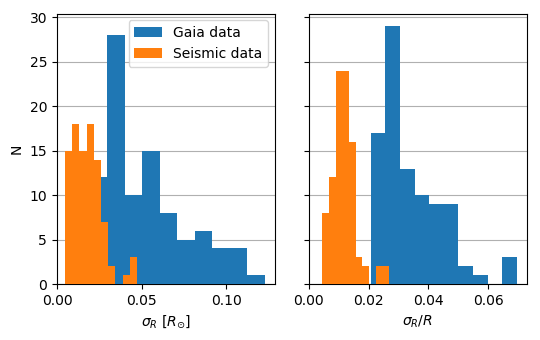

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5.5, 3.5))
ax1.hist(sa.rad_gaia_unc, alpha=1, label='Gaia data', zorder=3)
ax1.hist(sa.rad_unc, alpha=1, label='Seismic data', zorder=4)
#ax1.hist(sa.rad_scal_unc, alpha=1, zorder=2)
ax2.hist(sa.rad_gaia_unc/sa.rad_gaia, alpha=1, label='Gaia data', zorder=3)
ax2.hist(sa.rad_unc/sa.rad, alpha=1, label='Seismic data', zorder=4)
#ax2.hist(sa.rad_scal_unc/sa.rad_scal, alpha=1, zorder=2)

ax1.set_ylabel('N')
ax1.set_xlabel(r'$\sigma_{R}$ [$R_{\odot}$]')
ax2.set_xlabel(r'$\sigma_{R} / R$')
ax1.grid(axis='y', zorder=0)
ax2.grid(axis='y', zorder=0)
ax1.set_xlim(left=0)
ax2.set_xlim(left=0)
ax1.legend()

fig.tight_layout()
fig.savefig('figures/rad_hist.pdf')
plt.show()

The uncertainties on the Gaia radii are dominated by uncertainties in the angular diamters as shown in the following figure.

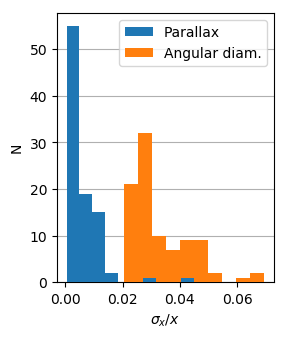

In [44]:
fig, ax = plt.subplots(figsize=(2.8, 3.5))
ax.hist(sa.plx_unc/sa.plx, label='Parallax', zorder=4)
ax.hist(sa.angdiam_unc/sa.angdiam, label='Angular diam.', zorder=3)

ax.set_ylabel('N')
ax.set_xlabel(r'$\sigma_{x} / x$')
ax.grid(axis='y', zorder=0)
ax.legend()

plt.show()

### Absolute Differences <a class="anchor" id="abs_diff"></a>

We now look at the absolute radius differences.

The following code contains functions for calculating radius differences and ratios, and for plotting the differences.

In [45]:
def xy_diff(x, x_unc, y, y_unc):
    '''
    Calculate differences and propagated uncertainties between x and y.
    '''
    diff = x - y
    diff_unc = np.sqrt(x_unc**2 + y_unc**2)

    return diff, diff_unc

def xy_ratio(x, x_unc, y, y_unc):
    '''
    Calculate ratios and propagated uncertainties between x and y.
    '''
    r = x / y
    r_unc = r * np.sqrt((x_unc / x)**2 + (y_unc / y)**2)

    return r, r_unc

In [46]:
from scipy.stats import gaussian_kde
from scipy import odr as sodr


def odr_poly_fit(x, y, sx, sy, order=1):
    '''
    Fit a polynomial of a given order to the data x,y with uncertainties sx, sy
    using orthogonal distance regression as implemented in scipy.
    '''
    poly_model = sodr.polynomial(order)
    odr_data = sodr.RealData(x, y, sx, sy)

    odr_fit = sodr.ODR(odr_data, poly_model, beta0=[1.]*(order+1))
    odr_out = odr_fit.run()
    
    return odr_out


def plot_radcomp(rad, rad_unc, rad_gaia, rad_gaia_unc, ax, outliers=None, polyfit=None):
    '''
    Plot radius comparison. Optionally mark outliers in red.
    '''
    # Define outliers if given
    if outliers is not None:
        bf = np.isin(sa.ID, outliers)
    else:
        bf = np.zeros(len(sa.ID), dtype=bool)

    # Plot points and errorbars
    ax.scatter(rad_gaia[~bf], rad[~bf], s=18, edgecolors='k', linewidth=0.8, zorder=3)
    ax.scatter(rad_gaia[bf], rad[bf], marker='^', c='r', s=18, edgecolors='k', linewidth=0.8, zorder=3)
    ax.errorbar(rad_gaia[~bf], rad[~bf], xerr=rad_gaia_unc[~bf], yerr=rad_unc[~bf],
                ls='none', linewidth=1, zorder=2)
    ax.errorbar(rad_gaia[bf], rad[bf], xerr=rad_gaia_unc[bf], yerr=rad_unc[bf],
                ls='none', c='r', linewidth=1, zorder=2)

    # Optionally fit polynomial and plot it
    if polyfit is not None:
        fit = odr_poly_fit(rad_gaia[~bf], rad[~bf], rad_gaia_unc[~bf], rad_unc[~bf], order=polyfit)
        #fit.pprint()
        poly = np.poly1d(fit.beta[::-1])

        poly_x = np.linspace(np.min(rad_gaia), np.max(rad_gaia))
        poly_y = poly(poly_x)

        ax.plot(poly_x, poly_y, c='k', zorder=4)

        ax.text(0.75, 2.25, 'Slope of fit: ' + "{0:.3f}".format(round(fit.beta[1], 3)) + r' $\pm$ ' + "{0:.3f}".format(round(fit.sd_beta[1], 3)))

    ax.set_xlim([0.65, 2.5])
    ax.set_ylim([0.65, 2.5])
    ax.plot([0.65, 2.5], [0.65, 2.5], c='k', ls=':', zorder=0)

    ax.set_xlabel(r'$R_{\mathrm{Gaia}}$ [$R_{\odot}$]')
    ax.set_ylabel(r'$R_{\mathrm{seismic}}$ [$R_{\odot}$]')


def plot_radcomp2(rad, rad_unc, rad_gaia, rad_gaia_unc, axes, outliers=None, polyfit=None):
    '''
    Same as plot_radcomp but with a second subplot showing the
    differences between the two sets of radii.
    
    For best results, axes should be a tuple of two axes (ax1, ax2) where ax1 is
    on top of ax2.
    '''
    ax1, ax2 = axes
    # Plot radius comparison on first axis
    plot_radcomp(rad, rad_unc, rad_gaia, rad_gaia_unc, ax1, outliers, polyfit)

    rdiff, rdiff_unc = xy_diff(rad, rad_unc, rad_gaia, rad_gaia_unc)

    # Define outliers if given
    if outliers is not None:
        bf = np.isin(sa.ID, outliers)
    else:
        bf = np.zeros(len(sa.ID), dtype=bool)

    # Plot radius differences and errorbars
    ax2.scatter(rad_gaia[~bf], rdiff[~bf], s=18, edgecolors='k', linewidth=0.8, zorder=3)
    ax2.errorbar(rad_gaia[~bf], rdiff[~bf], yerr=rdiff_unc[~bf],
                 ls='none', linewidth=1, zorder=2)
    ax2.axhline(c='k', ls=':', zorder=0)

    # Calculate and write mean difference
    mean_diff = np.sum(rdiff[~bf]/rdiff_unc[~bf]**2) / np.sum(1/rdiff_unc[~bf]**2)
    mean_diff_unc = np.sqrt(1/np.sum(1/rdiff_unc[~bf]**2))
    ax2.text(0.6, 0.2, 'Mean difference: ' + "{0:.3f}".format(round(mean_diff, 3)) + r' $\pm$ ' + "{0:.3f}".format(round(mean_diff_unc, 3)))

    ax1.set_xlabel('')
    ax2.set_xlabel(r'$R_{\mathrm{Gaia}}$ [$R_{\odot}$]')
    ax2.set_ylabel(r'$R_{\mathrm{seismic}}-R_{\mathrm{Gaia}}$ [$R_{\odot}$]')
    
    
def plot_raddiff(rad, rad_unc, rad_gaia, rad_gaia_unc, ax, outliers=None, relative=False,
                 label=''):
    '''
    Plot radius differences as KDEs. Optionally leave out a number of outliers.
    '''
    rad_d, rad_d_unc = xy_diff(rad, rad_unc, rad_gaia, rad_gaia_unc)
    # Remove outliers if given, otherwise plot all
    if outliers is not None:
        bf = np.isin(sa.ID, outliers)
        rad_d = rad_d[~bf]
        rad_d_unc = rad_d_unc[~bf]

    rad_plot = rad_d/rad_d_unc if relative else rad_d

    rad_kde = gaussian_kde(rad_plot)
    if relative:
        x_plot = np.linspace(-3, 3, 100)
    else:
        x_plot = np.linspace(-0.2, 0.2, 100)
    
    ax.plot(x_plot, rad_kde(x_plot)/np.sum(rad_kde(x_plot)*np.diff(x_plot)[0]),
            label=label, zorder=2)
    ax.axvline(c='k', ls='--', zorder=0)
    ax.set_ylim(bottom=0)
    ax.set_xlim([x_plot[0], x_plot[-1]])

    if relative:
        ax.set_xlabel(r'$\Delta R / \sigma$')
    else:
        ax.set_xlabel(r'$\Delta R$ [$R_{\odot}$]')

    ax.set_ylabel('KDE')

Before plotting the data we note that a number of the stars may have Gaia radii which differ by several standard deviations from the seismic values. By setting the variable `outlier_cut` in the cell below it is possible to remove those stars for which the radius difference deviates from zero by more than `outlier_cut` standard deviations.

In [47]:
outlier_cut = 3.0

rdiff, rdiff_unc = xy_diff(sa.rad, sa.rad_unc, sa.rad_gaia, sa.rad_gaia_unc)
bad_ID = sa.ID[np.absolute(rdiff) - outlier_cut*rdiff_unc > 0]
print(bad_ID)

[ 3425851  6278762  7510397  7871531  8554498  8866102  9025370  9965715
 10454113]


We also set new parameters for the plots.

In [48]:
plt.rcParams.update({'xtick.top': True,
                     'ytick.right': True,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.minor.visible': True,
                     'ytick.minor.visible': True})

Here we plot the radius comparisons and differences for both sets of seismic parallaxes, and we mark the stars that are outliers in the individual frequency analysis (they may have ill-determined photometry).

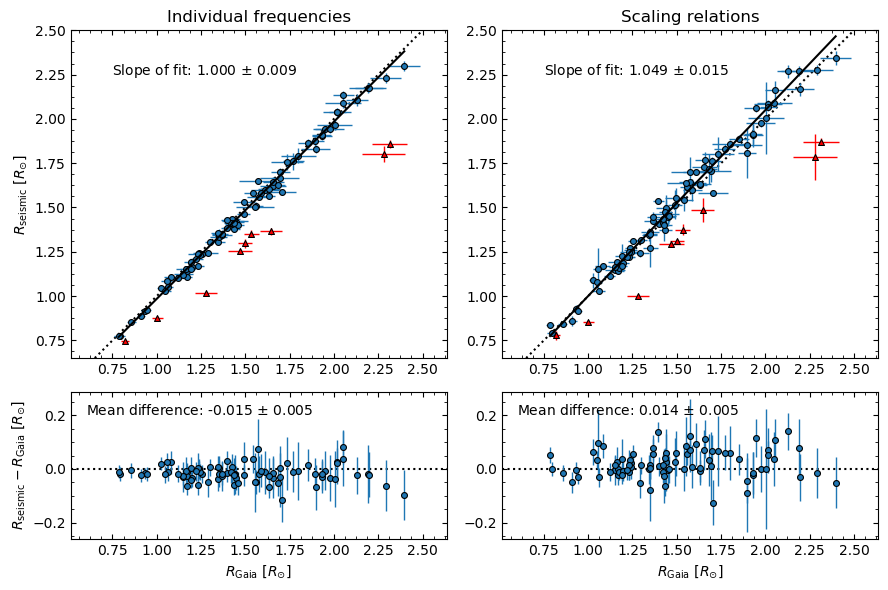

In [49]:
fig = plt.figure(figsize=(9,6))
ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0), sharex=ax1)
ax3 = plt.subplot2grid((3, 2), (0, 1), rowspan=2, sharex=ax1, sharey=ax1)
ax4 = plt.subplot2grid((3, 2), (2, 1), sharex=ax1, sharey=ax2)

plot_radcomp2(sa.rad, sa.rad_unc, sa.rad_gaia, sa.rad_gaia_unc, (ax1, ax2), outliers=bad_ID, polyfit=1)
plot_radcomp2(sa.rad_scal, sa.rad_scal_unc, sa.rad_gaia, sa.rad_gaia_unc, (ax3, ax4), outliers=bad_ID, polyfit=1)

ax1.set_aspect('equal')
ax3.set_aspect('equal')
ax1.set_title('Individual frequencies')
ax3.set_title('Scaling relations')
ax3.set_ylabel('')
ax4.set_ylabel('')

fig.tight_layout()
fig.savefig('figures/rad_compare.pdf')
plt.show()

Here we plot the radius differences for both sets of seismic parallaxes as KDEs.

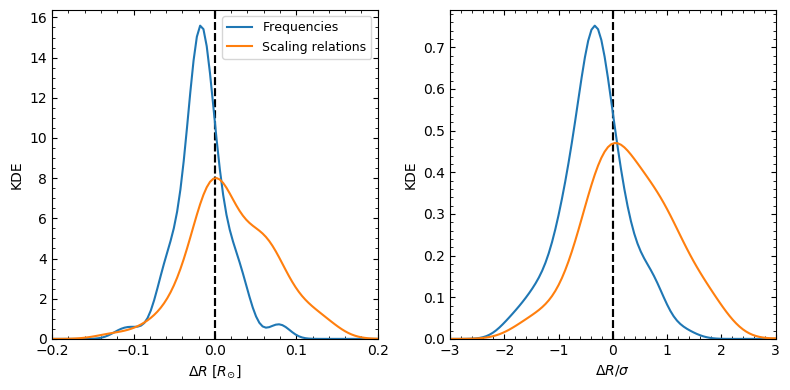

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
plot_raddiff(sa.rad, sa.rad_unc, sa.rad_gaia, sa.rad_gaia_unc, ax1, outliers=bad_ID, label='Frequencies')
plot_raddiff(sa.rad, sa.rad_unc, sa.rad_gaia, sa.rad_gaia_unc, ax2, outliers=bad_ID, relative=True)
plot_raddiff(sa.rad_scal, sa.rad_scal_unc, sa.rad_gaia, sa.rad_gaia_unc, ax1, outliers=bad_ID, label='Scaling relations')
plot_raddiff(sa.rad_scal, sa.rad_scal_unc, sa.rad_gaia, sa.rad_gaia_unc, ax2, outliers=bad_ID, relative=True)
ax1.legend(fontsize=9)
fig.tight_layout()
fig.savefig('figures/rad_diff.pdf')
plt.show()

We remove the outliers and output the mean radius offset

In [51]:
# Pick out stars which are not in the bad_ID list
saf = sa[~np.isin(sa.ID, bad_ID)]
print('Stars left after outlier removal:', len(saf))
print()

# Print weighted mean offset and uncertainty on the mean
rdiff2, rdiff2_unc = xy_diff(saf.rad, saf.rad_unc, saf.rad_gaia, saf.rad_gaia_unc)
print('Weighted mean offset for individual frequency data before outlier removal:')
print(np.sum(rdiff/rdiff_unc**2) / np.sum(1/rdiff_unc**2), np.sqrt(1/np.sum(1/rdiff_unc**2)))
print('\nWeighted mean offset for individual frequency data after outlier removeal:')
print(np.sum(rdiff2/rdiff2_unc**2) / np.sum(1/rdiff2_unc**2), np.sqrt(1/np.sum(1/rdiff2_unc**2)))

Stars left after outlier removal: 84

Weighted mean offset for individual frequency data before outlier removal:
-0.02721214966928566 0.004406285777026403

Weighted mean offset for individual frequency data after outlier removeal:
-0.015378546522349957 0.00462122018479617


### Relative Differences <a class="anchor" id="rel_diff"></a>

It is also interesting whether the observed offset depends on the stellar parameters like the effective temperature or the metallicity.
In the following we compare the ratios of seismic and Gaia radii as a function of these parameters. The ratios are binned in order to reduce the clutter of the plots.

In [52]:
rrat, rrat_unc = xy_ratio(saf.rad, saf.rad_unc, saf.rad_gaia, saf.rad_gaia_unc)
print('Weighted mean relative offset after outlier removal:')
print(np.sum(rrat/rrat_unc**2) / np.sum(1/rrat_unc**2), np.sqrt(1/np.sum(1/rrat_unc**2)))

Weighted mean relative offset after outlier removal:
0.9875228929190093 0.003531499090088204


In [53]:
def binned_ratios(bin_array, bins, r, r_unc):
    '''
    Bin the data in `r` according to the values in bin_array
    and the given bins.
    The weighted mean and standard deviation of the ratios in each of
    the bins are returned as arrays.
    '''
    # Find out which bin each of the values belong in
    nbins = len(bins)-1
    inds = np.digitize(bin_array, bins, right=True)

    # Initialize arrays
    binx = np.zeros(nbins)
    bin_mean = np.zeros(nbins)
    bin_std = np.zeros(nbins)

    # For each bin the weighted mean and standard deviation of the ratios
    # are calculated and stored
    for i in range(nbins):
        where = np.where(inds == i+1)
        bin_r = r[where]
        bin_r_unc = r_unc[where]

        bin_mean[i] = np.sum(bin_r/bin_r_unc**2) / np.sum(1/bin_r_unc**2)
        bin_std[i] = np.sqrt(1/np.sum(1/bin_r_unc**2))

    return bin_mean, bin_std

In [54]:
def plot_rad_ratio(rad, rad_unc, rad_gaia, rad_gaia_unc, ax, xax='teff', errors=True,
                   plabel=None):
    '''
    Plot the ratios of seismic and Gaia radii as a
    function of either effective temperature or metallicity.
    Optionally add errobars and labels.
    '''
    # Calculate parallax ratios
    rad_r, rad_r_unc = xy_ratio(rad, rad_unc, rad_gaia, rad_gaia_unc)

    # Define xaxis bins depending on the xaxis variable
    if xax == 'teff':
        bin_array = saf.teff
        bins = np.arange(5300, 6800, 200, dtype=int)
        bin_centers = np.arange(5400, 6700, 200, dtype=int)
    elif xax == 'feh':
        bin_array = saf.feh
        bins = np.arange(-0.6, 0.45, 0.1)
        bin_centers = np.arange(-0.55, 0.4, 0.1)

    # Calculate and plot binned means and standard deviations
    bin_mean, bin_std = binned_ratios(saf[xax], bins, rad_r, rad_r_unc)
    if errors:
        ax.errorbar(bin_centers, bin_mean, yerr=bin_std, marker='o',
                    c='k', linestyle='--', capsize=0, label=plabel)
    else:
        ax.plot(bin_centers, bin_mean, marker='o', c='k', mfc='none', linestyle=':',
                label=plabel)

def plot_rad_ratios(rad1, rad2, rad_gaia, ax, xax='teff',
                    ast_label1=None, ast_label2=None):
    '''
    Plot ratios of seismic and Gaia radii for both sets of seismic
    radii with errorbars only on one of the sets.
    '''
    plot_rad_ratio(*rad1, *rad_gaia, ax, xax, errors=True, plabel=ast_label1)
    plot_rad_ratio(*rad2, *rad_gaia, ax, xax, errors=False, plabel=ast_label2)
    ax.axhline(y=1, c='k', ls='--', lw=1)

    if xax == 'teff':
        ax.set_xlim([5300, 6800])
        ax.set_xlabel('Effective temperature [K]')
    elif xax == 'feh':
        ax.set_xlim([-0.6, 0.4])
        ax.set_xlabel('Metallicity [Fe/H]')

    ax.set_ylim([0.94, 1.08])
    ax.set_ylabel(r'$R_{\mathrm{seismic}}$ / $R_{\mathrm{Gaia}}$')
    if ast_label1 is not None or ast_label2 is not None:
        ax.legend(ncol=2)

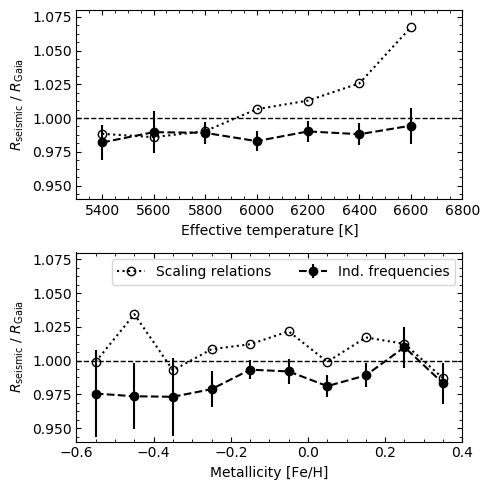

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_rad_ratios((saf.rad, saf.rad_unc), (saf.rad_scal, saf.rad_scal_unc),
                (saf.rad_gaia, saf.rad_gaia_unc), ax1, xax='teff')
plot_rad_ratios((saf.rad, saf.rad_unc), (saf.rad_scal, saf.rad_scal_unc),
                (saf.rad_gaia, saf.rad_gaia_unc), ax2, xax='feh',
                ast_label1='Ind. frequencies', ast_label2='Scaling relations')

fig.tight_layout()
fig.savefig('figures/rad_ratio.pdf')
plt.show()

It is interesting that the two sets of seismic radii agree at around the solar temperature $T_{\mathrm{eff},\odot} = 5777$ K since this is where the scaling relations are most accurate due to the way they scale relative to the solar values.
In the interactive plot below, it is possible to explore changes in the plot when all angular diameters are multiplied by a common factor. It is also possible to make the factor which is multiplied on the radii temperature dependent.

In [56]:
def plot_rad_ratio_int(gaia_offset=0.0, rad_factor=1.00,
                       rad_scal_factor=1.00, angdiam_factor=1.00,
                       xax='teff', rfactor='const', scaling='original'):
    '''
    Function for interactive plotting of radius ratios.
    '''
    plx = saf.plx + gaia_offset
    # Choose between a constant factor on the radius or one that
    # increases with temperature to reach the input value at 6600 K.
    if rfactor == 'const':
        rad = saf.rad * rad_factor
        if scaling == 'original':
            rad_scal = saf.rad_scal * rad_scal_factor
        elif scaling == 'corrected':
            rad_scal = saf.rad_scal_corr * rad_scal_factor
    elif rfactor == 'lin_teff':
        rad = saf.rad * (1 + (rad_factor - 1)*(saf.teff - 5400)/1200)
        if scaling == 'original':
            rad_scal = saf.rad_scal * (1 + (rad_scal_factor - 1)*(saf.teff - 5400)/1200)
        elif scaling == 'corrected':
            rad_scal = saf.rad_scal_corr * (1 + (rad_scal_factor - 1)*(saf.teff - 5400)/1200)
    angdiam = saf.angdiam * angdiam_factor
    
    # Calculate new Gaia radii after scaling
    radg = rad_gaia(plx, angdiam)
    
    # Plot ratios
    fig, ax = plt.subplots(figsize=(5.5,3.))
    plot_rad_ratios((rad, saf.rad_unc), (rad_scal, saf.rad_scal_unc),
                    (radg, saf.rad_gaia_unc), ax, xax,
                    ast_label1='Individual frequencies', ast_label2='Scaling relations')
    fig.tight_layout()
    plt.show()

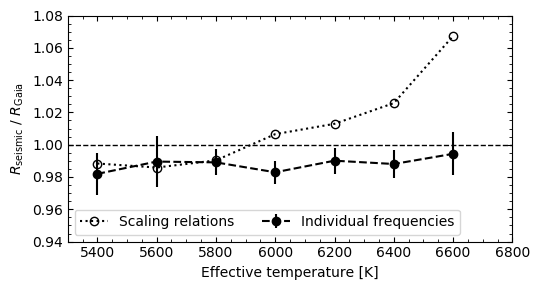

In [57]:
from ipywidgets import interactive
int_plot = interactive(plot_rad_ratio_int, gaia_offset=(-0.3, 0.3, 0.02),
                                           rad_factor=(0.9, 1.1, 0.01),
                                           rad_scal_factor=(0.9, 1.1, 0.01),
                                           angdiam_factor=(0.9, 1.1, 0.01),
                                           xax=['teff', 'feh'],
                                           rfactor=['const', 'lin_teff'],
                                           scaling=['original', 'corrected'])
int_plot

## Correcting the Scaling Relations <a class="anchor" id="scal_corr"></a>

Finally, we test the radii from the scaling relations after applying the correction factor to $\Delta\nu$.
For a few stars we were unable to correct the frequencies for the surface effect. We start by excluding these stars.

In [58]:
print('Excluded:', saf.ID[np.isnan(saf.fdnuDnufit)])
saf = saf[~np.isnan(saf.fdnuDnufit)]
print('Number of stars left:', len(saf))

Excluded: [4141376 5094751 6196457 8478994]
Number of stars left: 80


In [59]:
from scipy import stats

def poly_fit(x, y, y_unc, xp_lim, order=1, n_boot=10000):
    '''
    Fit a polynomial of order `order` to the data x,y with
    uncertainties in the y-values. Bootstrapping is applied
    to return lower and upper 1-\sigma uncertainty regions.
    '''
    # Fit a polynomial to the data in the given x-range.
    px = np.linspace(xp_lim[0], xp_lim[1])
    pfit_coeff, pfit_cov = np.polyfit(x, y, order, w=1/y_unc**2, cov=True)
    slope, slope_var = pfit_coeff[0], pfit_cov[0,0]

    tt = slope / np.sqrt(slope_var)
    pval = stats.t.sf(np.abs(tt), len(x)-1)*2

    poly = np.poly1d(pfit_coeff)
    py = poly(px)

    # Repeat the fit for n_boot bootstrap samples.
    boot_results = np.zeros((n_boot, len(px)))
    boot_slope = np.zeros(n_boot)
    for i in range(n_boot):
        rand_per = np.random.randint(len(x), size=len(x))
        synth_x = x[rand_per]
        synth_y = y[rand_per]
        synth_y_unc = y_unc[rand_per]

        pfit = np.polyfit(synth_x, synth_y, order, w=1/synth_y_unc**2)
        poly = np.poly1d(pfit)
        py_temp = poly(px)

        boot_results[i, :] = py_temp
        boot_slope[i] = pfit[0]

    # Calculate the 16th and 84th percentile at each x-value
    # and return as lower and upper uncertainty regions.
    boot_lower = np.percentile(boot_results, 16, axis=0)
    boot_upper = np.percentile(boot_results, 84, axis=0)

    return px, py, boot_lower, boot_upper, slope, slope_var, pval

Standard deviation Asfgrid correction: 0.02632165598498626
Standard deviation $\Delta\nu_{\mathrm{fit}}$ correction: 0.026442801551691375
Standard deviation $\Delta\nu_{\mathrm{fit}}$ correction with surface term: 0.0250764918855443


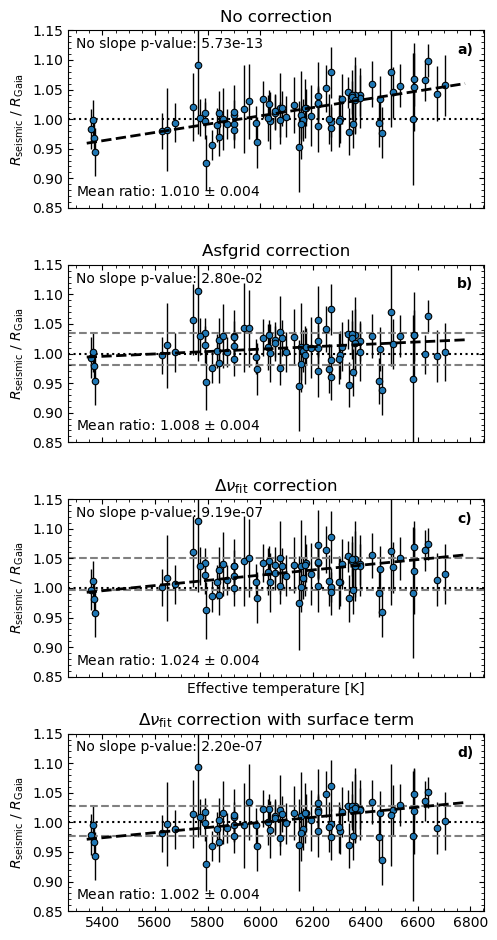

In [60]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,9.5), sharex=True, sharey=True)

axes = (ax1, ax2, ax3, ax4)
titles = ('No correction', r'Asfgrid correction',
          r'$\Delta\nu_{\mathrm{fit}}$ correction',
          r'$\Delta\nu_{\mathrm{fit}}$ correction with surface term')
panels = ('a)', 'b)', 'c)', 'd)')

for i, (rad, rad_unc) in enumerate(((saf.rad_scal, saf.rad_scal_unc),
                                    (saf.rad_scal_asf, saf.rad_scal_asf_unc),
                                    (saf.rad_scal_dnufit, saf.rad_scal_dnufit_unc),
                                    (saf.rad_scal_dnufit_corr, saf.rad_scal_dnufit_corr_unc))):
    ax = axes[i]
    rad_r, rad_r_unc = xy_ratio(rad, rad_unc, saf.rad_gaia, saf.rad_gaia_unc)
    rad_r_mean = np.sum(rad_r/rad_r_unc**2) / np.sum(1/rad_r_unc**2)
    rad_r_mean_unc = np.sqrt(1/np.sum(1/rad_r_unc**2))

    ax.scatter(saf['teff'], rad_r, edgecolors='k', s=22, linewidth=0.8,
               zorder=1)
    ax.errorbar(saf['teff'], rad_r, yerr=rad_r_unc, linestyle='none',
                c='k', capsize=0, lw=1, zorder=0)

    fit_filt = (saf['teff'] > 5600) & (saf['teff'] < 6400)
    #px, py, py_low, py_high, slope, slope_var, slope_pval = poly_fit(saf['teff'][fit_filt], rad_r[fit_filt], rad_r_unc[fit_filt], [5600., 6400.], 1)
    px, py, py_low, py_high, slope, slope_var, slope_pval = poly_fit(saf['teff'], rad_r, rad_r_unc, [5340., 6780.], 1)
    slope_std = np.sqrt(slope_var)

    ax.plot(px, py, c='k', ls='--', linewidth=2, zorder=2)
    #ax.fill_between(px, py_low, py_high, alpha=0.6, zorder=2)
    ax.axhline(y=1, c='k', ls=':', zorder=0)

    if i != 0:
        avg = np.average(rad_r, weights=1/rad_r_unc**2)
        std = np.sqrt(np.average((rad_r-avg)**2, weights=1/rad_r_unc**2))
        ax.axhline(y=avg+std, c='grey', ls='--', zorder=0)
        ax.axhline(y=avg-std, c='grey', ls='--', zorder=0)
        print('Standard deviation', titles[i]+':', std)
    ax.text(5300, 0.87, 'Mean ratio: ' + "{0:.3f}".format(round(rad_r_mean, 3)) + r' $\pm$ ' + "{0:.3f}".format(round(rad_r_mean_unc, 3)))
    #ax.text(5460, 1.12, 'Slope of fit: ' + "{0:.1e}".format(slope) + r' $\pm$ ' + "{0:.1e}".format(slope_std))
    ax.text(5300, 1.12, 'No slope p-value: ' + "{0:.2e}".format(slope_pval))
    ax.text(6750, 1.11, panels[i], weight='bold')

    ax.set_ylim([0.85, 1.15])

    ax.set_ylabel(r'$R_{\mathrm{seismic}}$ / $R_{\mathrm{Gaia}}$')
    ax.set_title(titles[i])

ax3.set_xlabel('Effective temperature [K]')

fig.tight_layout()
fig.savefig('figures/rad_ratio_fit.pdf')
plt.show()